In [4]:
from importer import *
sN = slice(None)
now = datetime.now()
# results_uid       = now.strftime("%Y%m%d-%H%M%S")
results_uid       = '20231103-190844'
results_dir       = get_root(f'results', results_uid)
figdir            = results_dir.append('figures')
results_file      = results_dir.append('result_dict.pkl')
restats_file      = results_dir.append('result_and_stats_dict.pkl')
dl_aggregate_file = results_dir.append('aggregate_dict.pkl')  # Stores models
os.makedirs(figdir, exist_ok=True)
print('Results stored at:', results_dir)

Results stored at: D:\repositories\ENIGMA\results\20231103-190844


# Predicting Antidepressant Treatment Response from Cortical Structure on MRI: A Mega-Analysis from the ENIGMA-MDD Working Group
In this notebook we will traverse through the data in the same order that things are discussed in the manuscript:
1. Load, join and clean data
2. Data inspection and exploration
3. Preparation of Machine Learning Set Up
4. Train Machine Learning Models
5. Calculate and Print Statistics
6. Interpretation of Results

## 1. Load, join and clean data
Each partner in the ENIGMA consortium provided three types of data:
* `dbc` Demographic, Behavioural and Clinical patient data
* `roi` Cortical measurements on thickness and surface area for each anatomical Region Of Interest
* `map` A 2D projection of the surface data underlying to the `roi` data type.
Let us start with loading and cleaning this data.

### 1.1 Load, join and clean data
#### 1.1.1 Load Structured data
We first load the data and join sheets using the `load_and_join_dfs` method, which is not fancy only performs an inner join on the two number of data frames.

In [5]:
path_roi = get_root('data', 'ENIGMA_MDD_patients-included_data-subcortical.csv')
path_dbc = get_root('data', 'ENIGMA_MDD_patients-included_data-clinical.csv')
data = load_and_join_dfs(path_dbc, path_roi)

#### 1.1.2 Load 2D-projections of cortical thickness and area
After loading the structured `dbc` and `roi` data, we now load the `map` 2D-projection data.
Briefly on the `map` data: it represents the thickness of an individual on the surface of a hemisphere of the brain. The brain hemisphere is represented as a 3D mesh, you can imagine this as a 3D point cloud, the points are called vertex, plural vertices. Thus, the original data was just a long list (164k) of thickness values (scalars) for each vertex in the mesh. By inflating the hemisphere we can find the position of each scalar on the surface of a sphere. The scalar values were then projected to a plane using stereographic projection using `s12_sphere2place.py`. This code makes sure that left an right hemispheres line up very well (Fig 2.). This scalar data was supplied to us as GIfTY file type. GIfTY (`.gii`) is the geometric equivalent to NIfTY (`.nii`) files, `s12_sphere2place.py` converts this into 2D NumPy arrays, which is the only thick we will be working with in this Notebook. We Clean the data right away by: removing borders, converting it to a 1D vector and dropping zero variance pixels.

In [74]:
# Remove edges and extra channel, and make it into a nice DataFrame with x,y pixel coordinates as column labels
dim = 128
X_thc, X_thc_arr = load_proj_df(data, 'Thickness', dim=dim)
X_are, X_are_arr = load_proj_df(data, 'Area', dim=dim)

100%|██████████| 258/258 [00:02<00:00, 120.52it/s]


### 1.2 Sanitizing and feature engineering
#### 1.2.1 Removing zero variance pixels from 2D projection data

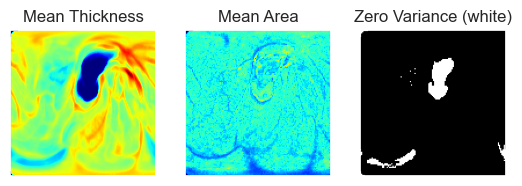

In [7]:
# Find zero variance (corpus callosum (CC))
bool_var = [var < 0.005 for _,   var in X_thc.var().iteritems()]
zero_var = [col for col, var in X_thc.var().iteritems() if var < 0.002]

# Drop CC
X_thc = X_thc.drop(columns=zero_var)
X_are = X_are.drop(columns=zero_var)

# Visualization of loaded data
fig, axes = plt.subplots(1, 3)
img_arrays = X_thc_arr.mean(axis=0)[0], X_are_arr.mean(axis=0)[0], np.array(bool_var).reshape(dim - 2, dim - 2)
titles = 'Mean Thickness', 'Mean Area', 'Zero Variance (white)'
cmaps = 'jet', 'jet', 'gray'
for ax, arr, title, cmap in zip(axes, img_arrays, titles, cmaps):
  ax.imshow(arr, cmap=cmap)
  ax.set(title=title, xticks=[], yticks=[])

#### 1.2.2 Normalized Symptom Severity
Secondly we clean the joined data frame using  the `clean_data_df` method. Although this method is mainly concerned with the sanitation of data, (e.g. renaming AO to Age_of_Onset) it also introduces `Normalized_Pretreatment_Severity`, a single numeric pretreatment symptom score. Briefly, we center all scoring methods around zero, and rescale them to their standard deviation. The normalized score we use is preferably MADRS, then HDRS, then BDI, depending on what is available. Since some subjects have more than one scoring we can check if different scoring lists are actually correlated. Correlations are fine (Fig.1)

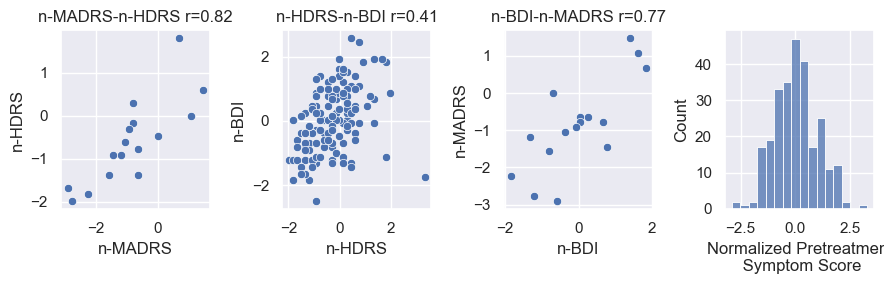

In [11]:
data, norm_fig = clean_data_df(data, drop_old_symptom_scores=True)
norm_fig.savefig(figdir.append('NormalizedSeverityScores.png'))

Three instruments to score treatment were used across all cohorts. The following scoring methods were used per site. The method used in order of preference is MADRS, HDRS then BDI.

In [12]:
score_df = pd.DataFrame(columns=['MADRS', 'HDRS', 'BDI'])
for cohort in cohorts:
  cohort_data = pd.DataFrame(data=data[data.cohort == cohort.key], columns=data.columns)
  if len(cohort_data):
    contains = lambda scoring_method: cohort_data[f'{scoring_method}_pre'].notna().sum()
    score_df.loc[f'{cohort.name} (N={len(cohort_data)})'] = [f'{contains(score)}'.ljust(12) if contains(score) else ''.ljust(12) for score in ('MADRS', 'HDRS', 'BDI')]
score_df

,MADRS,HDRS,BDI
AFFDIS (N=16),16,16,16
DEP-ARREST-CLIN (N=57),,57,
Hiroshima cohort (N=103),,103,103
Melbourne (N=49),49,,
Minnesota (N=13),,,13
Milano OSR (N=27),,26,19


#### 1.2.3 Treatment Type
Convert cells with treatment type information into column categories.

In [13]:
# Split up the treatment information into separate boolean columns
drug_types = set(flatten(data['Treatment_type_category'].values))
for drug_type in drug_types:
  data[f'uses_{drug_type}'] = [drug_type in i for i in data['Treatment_type_category']]

#### 1.2.4 Extreme non-responders/responders
Let us also insert an `is_extreme label`, we will talk about the "Extremes subpopulation" later

In [14]:
q1, q3 = np.percentile(data['Response_percentage'], [25 , 75])
data.insert(loc=0, column='is_extreme', value=[(data['Response_percentage'] < q1) | (data['Response_percentage'] > q3)][0])

### 1.3 Defining Population Subgroups
Now that we know that there are substantial differences among sites in our full data set (`total`) we would like to define more homogeneous subgroups for future analyses. Due to the differences in both measured training data as primary outcomes we would like to initially define two subgroups. The first consists of just a single site, namely the Hiroshima cohort (`Hiroshima`), since it has the largest sample size and its population characteristics are reflective of the larger study. Second, we define a subpopulation as showing a similar treatment response rate under 50% (`Same_resp`). The three cohorts we chose we AFFDIS, Hiroshima cohort and Melbourne. Lastly, we define a third subgroup. These are subjects in the upper and lower qualtile in terms of treatment response. The hypothesis behind this subpopulation is that if there is a treatment effect in the data, one would expect this to be larger in patients showing more response.

Let us define subsets of our full data frame. Let us define the indices for each of our population subgroups that we can use to filter our data frame later:

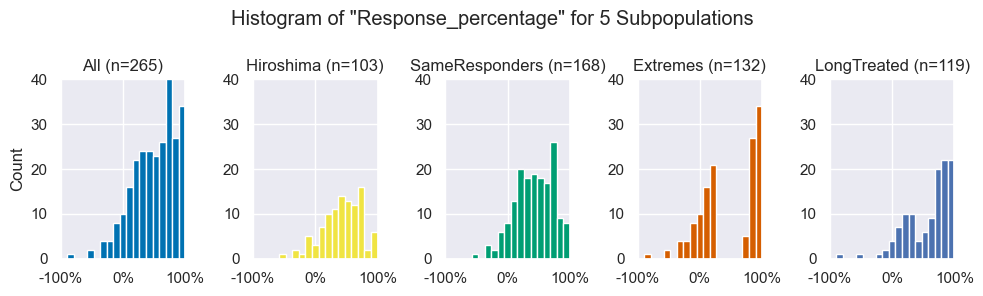

In [185]:
same_responders = 'AFFDIS', 'Hiroshima', 'Melb'
long_treated = 'MOODS', 'Melb', 'Minnesota'
q1, q3 = np.percentile(data['Response_percentage'], [25 , 75])
populations = {
  'All': data.index,
  'Hiroshima': data[data.cohort == 'Hiroshima'].index,
  'SameResponders': pd.Index([i for i in data.index if i.split('_')[0] in same_responders]),
  'Extremes': data[data.is_extreme].index,
  'LongTreated': pd.Index([i for i in data.index if i.split('_')[0] in long_treated]),
}

# Plot histograms of response percentage for each subpopulation
resp_fig = subpop_hists(data, populations)
resp_fig.savefig(figdir.append('ResponseHistogram.png'))
plt.show()

Later on in this study, we present interesting findings in the Extremes subpopulation. An alternative explanation was that treatment duration could positively affect treatment outcome (longer follow up -> more chance to recover), thus that prediction in the Extremes cohort would primarily separate cohorts, and coincidentally, response and non-response. Our six cohorts do show an interesting difference among follow-up durations (see table below or table 1 in the manuscript). We roughly split them up in a group of Short treated ( < 6 weeks ) and `LongTreated` ( > 10 weeks ).

The hypothesis that the results in the Extremes population stems from a selection bias is weakened by the fact that the Extremes subpopulation consists of substantial (>37%) parts of each cohort. Additionally, the histogram of the Response_percentage in the LongTreated population does not have a clear trend to the right that supports the hypothesis that a longer follow-up leads to higher response rates. For details on this population see the table below.

However, interestingly, the `LongTreated` histogram shape looks like a blend between the `All` population and `Extremes` subpopulation, balanced accuracy in the `LongTreated` subpopulation as bad (49.7%) as in the `All` population (47.7%), especially when compared to the `Extremes` subpopulation (68.6%).
Adding the `LongTreated` subgroup will not affect our later analyses because we will tell the `distiller` object to look at the `All` population by default.

In [183]:
duration_based_cohort_printer = lambda in_only: '\n  '.join([''.join([
    c.name.ljust(20),
    f'n={data.cohort.value_counts()[c.key]}'.ljust(7),
    f'{data[data.cohort == c.key].is_responder.mean():.1%}  ',
    f'{str(c.treatment_duration_mu).rjust(4)}+{c.treatment_duration_sd}'
])  for c in cohorts if c.key in set(data.cohort) and (c.key in long_treated if in_only else c.key not in long_treated)])

print('Long treated:\n ', duration_based_cohort_printer(True), '\nShort treated:\n ', duration_based_cohort_printer(False))

Long treated:
  DEP-ARREST-CLIN     n=57   84.2%  12.0+0.0
  Melbourne           n=49   44.9%  12.0+0.0
  Minnesota           n=13   61.5%   9.9+2.0 
Short treated:
  AFFDIS              n=16   37.5%   5.1+0.7
  Hiroshima cohort    n=103  46.6%   6.0+0.0
  Milano OSR          n=27   55.6%   4.2+0.7


## 2. Population and data exploration
The ENIGMA consortium provided is with a large amount of subjects from a number of consortia. It is crucial to have a good grasp of the properties of our population as well as differences among sites for the design of our methods and the interpretation of our results

### 2.1 Inspect Patient selection
We start off with a table that shows exclusion of patients. In the code below we go through two exclusion steps: First to select patients with follow-up data available for our classification target, second with complete data available for training. Thus, we go through three stages which we call: `stg1`, `stg2` and `stg3`, of which the last one is equal to the cleaned data set `data` above.

In [16]:
# Load subjects in Stage 1
path_stg1 = get_root('data', 'ENIGMA-MDD_patients-all_data-clinical.csv')
df_stg1 = pd.read_csv(path_stg1, index_col='SubjID').iloc[: , 1:]
# Load subjects in Stage 2
df_stg2 = pd.read_csv(path_dbc, index_col='SubjID', sep=';')
# We already have Stage 3
df_stg3 = data
# For Stage 4 we need to edit our projections data frame a bit
df_stg4 = X_thc.loc[[i for i in X_thc.index if 'LH' in i]]
df_stg4.index = df_stg4.index.map(lambda x: x.split('|')[0])

# Get the sites, and the data that are in each of the three steps
dfs = df_stg1, df_stg2, data, df_stg4,
sts = [sorted(set([i.split('_')[0] for i in df.index])) for df in dfs]

# Print a verbose overview of the subject selection process
print(f'Prior to subject selection (stage 1) we have {len(dfs[0])} subjects from {len(sts[0])} cohorts.')
print(f'After subject selection (stage 2) we have {len(dfs[1])} subjects from {len(sts[1])} cohorts.')
print(f'After checking for completeness of data for ROI analysis (stage 3) we still habe {len(dfs[2])} subjects from {len(sts[2])} cohorts.')
print(f'For Vec and 2D analysis, we have {len(dfs[3])} subjects from {len(sts[3])} cohorts')

# Print a table header
n_dfs = [{'Total':len(df), '--':0, **{f'{c.name} ({c.key})': len([i for i in df.index if c.key in i]) for c in cohorts}} for df in dfs]
n_all, n_cov, n_dat, _ = n_dfs

# We can split this up further
n_series = [pd.Series(data=n_df, name=f'Stage {i}') for i, n_df in enumerate(n_dfs, 1)]
series_list = flatten([[ser, None] for ser in n_series])[:-1]

# Set the even numbered columns
for i, (df_before, df_after) in enumerate(zip(dfs[:-1], dfs[1:])):
  series_list[1 + i * 2] = pd.Series(data={
      'Total': len(df_before) - len(df_after),
      '--':0,
      **{f'{cohorts[k].name} ({k})': len([i for i in df_before.index if i not in df_after.index and i.split('_')[0] == k]) for k in cohorts.keys()}
  }, dtype=float, name=f'--excl-->')
pd.concat(series_list, axis=1).fillna(0).astype(int).replace(0, '').head(12)

# Uncomment this line if you would like to see which subjects do NOT have Cortical Data
# print("Subjects without Raw Cortigal data are:\n  -", "\n  - ".join([i for i in df_stg3.index if i not in df_stg4.index]))

Prior to subject selection (stage 1) we have 795 subjects from 9 cohorts.
After subject selection (stage 2) we have 265 subjects from 6 cohorts.
After checking for completeness of data for ROI analysis (stage 3) we still habe 265 subjects from 6 cohorts.
For Vec and 2D analysis, we have 258 subjects from 6 cohorts


,Stage 1,--excl-->,Stage 2,--excl-->,Stage 3,--excl-->,Stage 4
Total,795,530,265,,265,7,258
--,,,,,,,
AFFDIS (AFFDIS),29,13,16,,16,,16
Cardiff (CARDIFF),40,40,,,,,
DEP-ARREST-CLIN (MOODS),64,7,57,,57,,57
Hiroshima cohort (Hiroshima),150,47,103,,103,1,102
Melbourne (Melb),156,107,49,,49,,49
Minnesota (Minnesota),70,57,13,,13,,13
Milano OSR (SanRaffaele),160,160,27,,27,6,21
Stanford TIGER (TIGER),48,48,,,,,


### 2.2 Inspect provided columns
Before we move to the `map` data, let us take a look at the `roi` data that we received.
There are also a lot of non-cortext columns. Do not worry about them, later on we will mention which are included in the model as BDC features explicitly.

In [17]:
# Load structured data
dkt_atlas_features = [i for i in data.columns if any([j in i for j in dkt_atlas_lut])]
subcortical_rois = [i for i in pd.read_csv(path_roi,sep=';', index_col='SubjID').columns if i[1] != '_' and not 'Site' in i][:-2]
subcortical_rois = [i for i in subcortical_rois if 'Thick' not in i and 'Surf' not in i]

print(f'The number of cortical features we found is {len(dkt_atlas_features)} ({32 * 2 * 3} = 32 ROIs × 2 maps (Thickness & Sufrace) × 3 hemispheres (Left, Right, Mean). That means there are {len(data.columns) - len(dkt_atlas_features)} non-surface columns.')
subc_rois = subcortical_rois
subc_no_icv = subc_rois[:-1]
print(f'\nWe also have ICV and {len(subc_rois) - 1} subcortical_rois:', ', '.join(subc_rois[:-1]))
unique_subc_rois = sorted(set([i[1:].capitalize() if i[0] in 'LRM' else i for i in subc_rois]))
print(f'Of these {len(unique_subc_rois)} are unique:', ', '.join(unique_subc_rois), 'Vent, LatVent and ICV are not included, so 7 remain.')
# data[dkt_atlas_features].head()  # You can take a look at the DKT Atlas features by uncommenting this line
data[subc_no_icv] = data[subc_no_icv].div(data['ICV'], axis=0)

The number of cortical features we found is 192 (192 = 32 ROIs × 2 maps (Thickness & Sufrace) × 3 hemispheres (Left, Right, Mean). That means there are 81 non-surface columns.

We also have ICV and 24 subcortical_rois: LLatVent, RLatVent, Lthal, Rthal, Lcaud, Rcaud, Lput, Rput, Lpal, Rpal, Lhippo, Rhippo, Lamyg, Ramyg, Laccumb, Raccumb, Mvent, Mthal, Mcaud, Mput, Mpal, Mhippo, Mamyg, Maccumb
Of these 10 are unique: Accumb, Amyg, Caud, Hippo, ICV, Latvent, Pal, Put, Thal, Vent Vent, LatVent and ICV are not included, so 7 remain.


### 2.3 General Population Characteristics
Each data set was collected using different inclusion protocols. Thus, our the population per site can vary a lot. Let us start with group level statistics. We first create a data frame containing subject properties per site called `site_stats` using the `collect_stats_per_site` method. This data frame will be the input to the `stacked_hist` method. This method can read a column from the `site_stats` table and create a stacked histogram. In addition to `site_stats` we also receive a `site_means` table, which contains the same information but nicely formatted for printing, so let us start with that:

As you can see, the percentage of participants that is female (`is_female`) is more than twice as high in the Milano OSR cohort than in the AFFDIS cohor. Also, mean age of the participants included (`Age`) varies (15.0 for the Minnesota, and 50.3 for Milano OSR. Lastly, response rate varies from 37% at AFFDIS to 74% for DEP-ARREST-CLIN.

In [18]:
site_stats, site_means = collect_stats_per_site(data)
site_means.T

Cohort,Total,AFFDIS,DEP-ARREST-CLIN,Hiroshima cohort,Melbourne,Minnesota,Milano OSR
Numel,265,16,57,103,49,13,27
ADcur,14.3 ± 77.4,10.8 ± 14.4,0.0 ± 0.0,1.3 ± 1.0,nan ± nan,nan ± nan,63.4 ± 163.5
Age,36.3 ± 15.2,44.1 ± 14.1,34.1 ± 12.7,43.4 ± 11.8,19.6 ± 3.0,15.0 ± 2.2,50.3 ± 9.9
Age_of_Onset,30.4 ± 15.0,35.6 ± 15.7,28.0 ± 11.7,39.4 ± 13.7,15.7 ± 2.7,11.2 ± 2.6,35.5 ± 11.5
Normalized_Pretreatment_Severity,0.03 ± 0.99,-0.85 ± 1.20,0.82 ± 0.80,-0.32 ± 0.80,0.28 ± 0.72,0.07 ± 0.99,-0.19 ± 1.07
Response_percentage,50.1% ± 35.1%,36.7% ± 35.5%,74.6% ± 23.1%,42.3% ± 30.9%,43.9% ± 30.0%,41.0% ± 60.6%,51.0% ± 37.8%
is_extreme,132 (49.8%),8 (50.0%),37 (64.9%),38 (36.9%),26 (53.1%),10 (76.9%),13 (48.1%)
is_female,158 (59.6%),5 (31.2%),39 (68.4%),53 (51.5%),33 (67.3%),9 (69.2%),19 (70.4%)
is_recurrent,156 (58.9%),15 (93.8%),29 (50.9%),50 (48.5%),31 (63.3%),9 (69.2%),22 (81.5%)
is_remitter,44.2% ± 49.7%,43.8% ± 49.6%,73.7% ± 44.0%,32.0% ± 46.7%,34.7% ± 47.6%,53.8% ± 49.9%,40.7% ± 49.1%


In [19]:
responder_stats, responder_means = collect_stats_per_site(data.loc[data.is_responder])
non_responder_stats, non_responder_means = collect_stats_per_site(data.loc[~data.is_responder])
non_vs_responders = pd.concat([site_means.T.Total, responder_means.T.Total, non_responder_means.T.Total], axis=1)
non_vs_responders.columns = ['Total','Responders', 'Non-responders']
non_vs_responders

,Total,Responders,Non-responders
Numel,265,147,118
ADcur,14.3 ± 77.4,7.0 ± 40.5,30.4 ± 123.3
Age,36.3 ± 15.2,35.1 ± 14.7,37.8 ± 15.6
Age_of_Onset,30.4 ± 15.0,29.8 ± 14.4,31.2 ± 15.7
Normalized_Pretreatment_Severity,0.03 ± 0.99,0.18 ± 0.98,-0.14 ± 0.97
Response_percentage,50.1% ± 35.1%,76.2% ± 14.5%,17.5% ± 24.4%
is_extreme,132 (49.8%),66 (44.9%),66 (55.9%)
is_female,158 (59.6%),85 (57.8%),73 (61.9%)
is_recurrent,156 (58.9%),79 (53.7%),77 (65.3%)
is_remitter,44.2% ± 49.7%,77.6% ± 41.7%,2.5% ± 15.7%


##### 2.4.1 Can the large differences in response rates among sites be explained?
We observe a large difference among sites in treatment response rate (37%-84%).
Is this obviously related to any other properties, say age, treatment duration or medication?

We find that this is the case, average age for responders is 35.1 and 37.8.
Average treatment duration is 9 weeks for responders, and 7.9 for non-responders.
Finally, we do find a large difference in the antidepressant used: 82% of SSRI-users does not respond, while 79% of SNRI-users does.
However, these properties are strongly correlated with site, 57/66 SNRI users are from the highest performing site with an average response rate of 84%.

In [20]:
covariates = 'Age', 'Treatment_duration', 'is_responder'
variables = ('is_responder', ), ('is_responder',), ('uses_SSRI', 'uses_SNRI', 'uses_ATYP')
response_correlates = pd.DataFrame(columns=['Population', 'Property', '+', '-', 'n+', 'n-'])
for covariate, variable in zip(covariates, variables):
    for var in variable:
        group_a = data[data[var]]
        group_b = data[~data[var]]
        num_a = group_a[covariate].mean()
        num_b = group_b[covariate].mean()
        fmt = '{:.1%}' if num_a < 1 else '{:.1f}'
        response_correlates.loc[len(response_correlates)] = var, covariate, fmt.format(num_a), fmt.format(num_b), len(group_a), len(group_b)
response_correlates

,Population,Property,+,-,n+,n-
0,is_responder,Age,35.1,37.8,147,118
1,is_responder,Treatment_duration,9.0,7.9,147,118
2,uses_SSRI,is_responder,46.7%,81.8%,199,66
3,uses_SNRI,is_responder,78.8%,47.7%,66,199
4,uses_ATYP,is_responder,53.3%,55.6%,15,250


### 2.4 Comparissons among cohorts
#### 2.4.1 Adolescents per cohort

In [21]:
adolescent_df = pd.DataFrame(columns=('N', '%'))
for cohort in [c for c in cohorts if c.name in site_stats.index]:
    adolescents = np.sum(site_stats.loc[cohort.name].Age < 20)
    total = site_stats.loc[cohort.name].Numel
    table_head = f'{cohort.name} (N={total})'
    adolescent_df.loc[table_head] = (adolescents, f'{adolescents / total * 100:.0f}')
adolescent_df

,N,%
AFFDIS (N=16),1,6
DEP-ARREST-CLIN (N=57),6,11
Hiroshima cohort (N=103),0,0
Melbourne (N=49),23,47
Minnesota (N=13),13,100
Milano OSR (N=27),0,0


#### 2.4.1 Symptom severity
Let us see if treatment response varies by site. This will be important for harmonization. The first way to look at it is simply looking at remission rates per site:

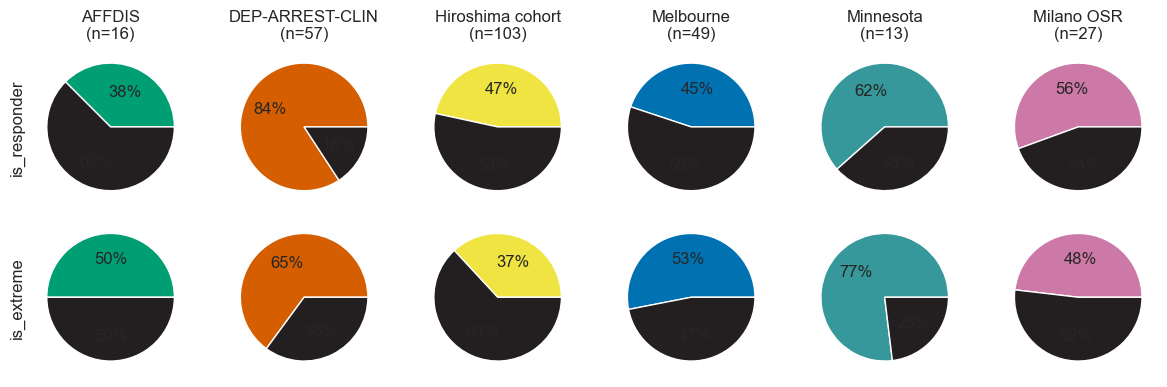

In [22]:
outcomes = 'is_female', 'is_responder', 'is_remitter', 'is_extreme'
outcomes_to_plot = outcomes[1], outcomes[3]
n_otp = len(outcomes_to_plot)
pie_fig, axes = plt.subplots(n_otp, len(set(data.cohort)), figsize=(12, 2 * n_otp))
#axes = axes.reshape(-1)
for u, outcome in enumerate(outcomes_to_plot): # 'is_remitter']):
  v = 0
  for cohort in cohorts:
    df_cohort = data[data.cohort == cohort.key]
    if not any(df_cohort.index):
      continue
    axes[u, v].pie(
      x=[df_cohort[outcome].sum(), len(df_cohort) - df_cohort[outcome].sum()],
      colors=(cohort.color, colors.dark),
      autopct='%.0f%%',
    )
    if not u:
        axes[u, v].set_title(f'{cohort.name}\n(n={len(df_cohort)})')
    if not v:
      axes[u, v].set_ylabel(outcome)
    v += 1
plt.tight_layout()
pie_fig.savefig(figdir.append('ResponseRateBySite.png'))
plt.show()

#### 2.4.2 Symptom development over time
Secondly, we look at the trends by plotting the change per site

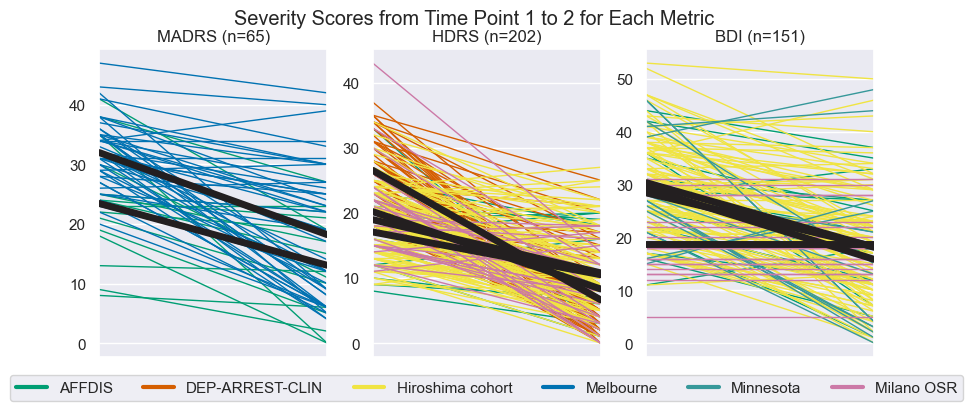

In [23]:
trend_fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for ax, score in zip(axes.reshape(-1), ('MADRS', 'HDRS', 'BDI')):
  for cohort in cohorts:
    # Get the values for a specific cohort and a specific symptom scoring method
    cohort_data = pd.DataFrame(data=data[data.cohort == cohort.key], columns=data.columns)
    pre   = cohort_data[score + '_pre'].notna()
    post  = cohort_data[score + '_post'].notna()
    subjs = cohort_data[(pre & post)]
    if not len(subjs):
      continue
    vals = subjs[[score + '_pre', score + '_post']].to_numpy().astype(int).T
    ax.plot(vals, color=cohort.color, lw=1)  # Plot the found individual lines
    ax.plot(vals.mean(axis=1), color=colors.dark, lw=5.0, zorder=3)  # And plot the mean in bold
  ax.set(xticks=(), xlim=(0, 1), title=f'{score} (n={data[score + "_pre"].notna().sum()})')
trend_fig.suptitle('Severity Scores from Time Point 1 to 2 for Each Metric')
# Format the legend
line_per_cohort = [Line2D([], [], color=c.color, label=c.name, lw=3) for c in cohorts if c.name in site_stats.index]
axes[1].legend(handles=line_per_cohort, ncol=len(site_stats.index), loc='center', bbox_to_anchor=(0.5, -.1))
trend_fig.savefig(figdir.append('ResponseTrends.png'))

### 2.5 Comparing subpopulations to the total population
#### 2.5.1 No differences in characteristics between entire population and the Extremes subpopulation
Later on in this work, we will find some interesting findings (good classification accuracy) for the "Extremes"  subpopulation, so let us take a look at these characteristics as well.

The underlying hypothesis for the formulation of this subpopulation was that - within MDD - there are different subpopulations with different a phenotype and different treatment response. However, simpler, alternative hypotheses, e.g. effects such as site, age or other clinical characteristics would be preferred. To verify the probability of the these hypotheses, we are interested in differences in population characteristics between the "Extremes" subpopulation and the total population, this is shown below. If anything stands out, this might weaken the belief in our primary hypothesis.

Under `Numel` we find that the Extremes subjects originate from all sites, and actually most sites also contributed about 50% to the Extremes subpopulation. In terms of `Age` or `is_female`, there are also no striking differences. This means that there is no clear evidence of the alternative hypotheses to our primary hypothesis.

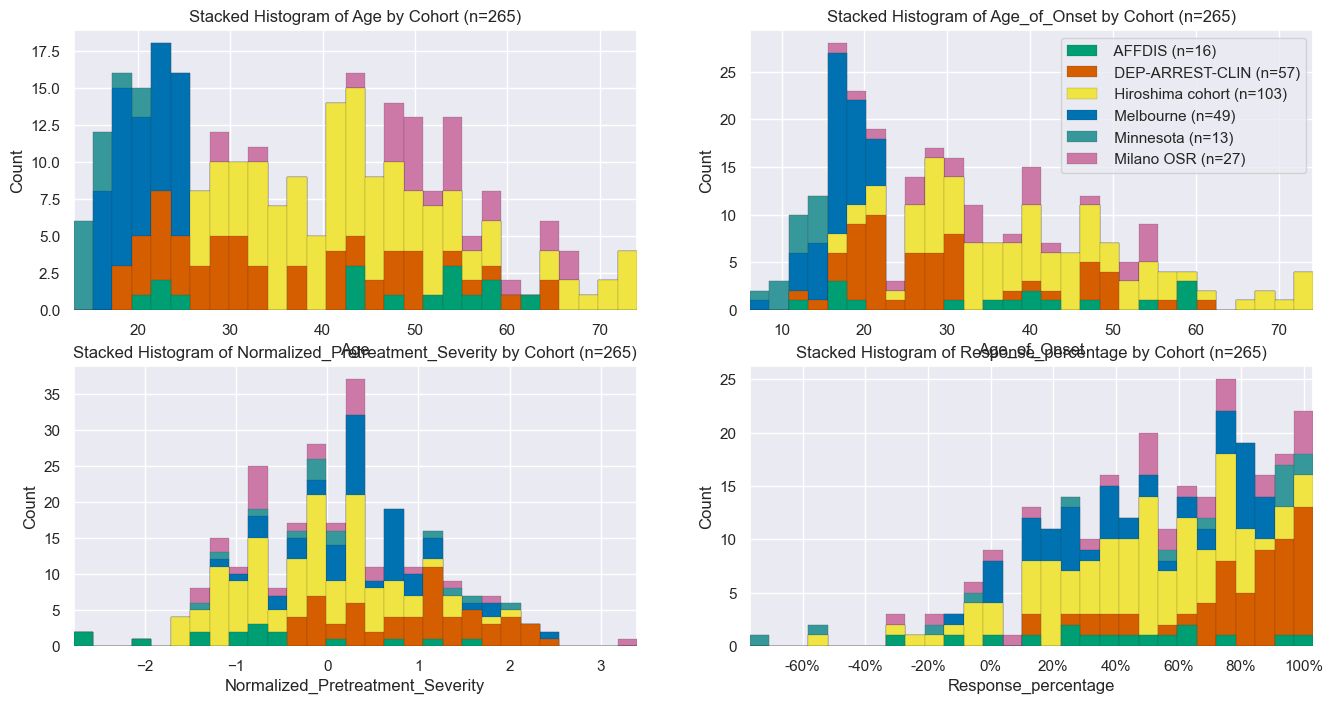

In [24]:
hist_fig, axes = plt.subplots(2, 2, figsize=(16, 8))
stacked_hist(data, site_stats, ax=axes[0, 0], make_legend=False, name='Age')
stacked_hist(data, site_stats, ax=axes[0, 1], make_legend=False, name='Age_of_Onset')
stacked_hist(data, site_stats, ax=axes[1, 0], make_legend=False, name='Normalized_Pretreatment_Severity')
stacked_hist(data, site_stats, ax=axes[1, 1], make_legend=True,  name='Response_percentage')
axes[1, 1].set_xticklabels([f'{t:.0%}' for t in axes[1, 1].get_xticks()])
hist_fig.savefig(figdir.append('ResponseHistogram.png'))
plt.show()

In [25]:
_, ss_means = collect_stats_per_site(data.loc[populations['Hiroshima']])
ss_means.T

Cohort,Total,Hiroshima cohort
Numel,103,103
ADcur,1.3 ± 1.0,1.3 ± 1.0
Age,43.4 ± 11.8,43.4 ± 11.8
Age_of_Onset,39.4 ± 13.7,39.4 ± 13.7
Normalized_Pretreatment_Severity,-0.32 ± 0.80,-0.32 ± 0.80
Response_percentage,42.3% ± 30.9%,42.3% ± 30.9%
is_extreme,38 (36.9%),38 (36.9%)
is_female,53 (51.5%),53 (51.5%)
is_recurrent,50 (48.5%),50 (48.5%)
is_remitter,32.0% ± 46.7%,32.0% ± 46.7%


In [26]:
_, rrs_means = collect_stats_per_site(data.loc[populations['SameResponders']])
rrs_means.T

Cohort,Total,AFFDIS,Hiroshima cohort,Melbourne
Numel,168,16,103,49
ADcur,4.8 ± 9.9,10.8 ± 14.4,1.3 ± 1.0,nan ± nan
Age,36.5 ± 15.0,44.1 ± 14.1,43.4 ± 11.8,19.6 ± 3.0
Age_of_Onset,32.0 ± 15.9,35.6 ± 15.7,39.4 ± 13.7,15.7 ± 2.7
Normalized_Pretreatment_Severity,-0.20 ± 0.89,-0.85 ± 1.20,-0.32 ± 0.80,0.28 ± 0.72
Response_percentage,42.3% ± 31.2%,36.7% ± 35.5%,42.3% ± 30.9%,43.9% ± 30.0%
is_extreme,72 (42.9%),8 (50.0%),38 (36.9%),26 (53.1%)
is_female,91 (54.2%),5 (31.2%),53 (51.5%),33 (67.3%)
is_recurrent,96 (57.1%),15 (93.8%),50 (48.5%),31 (63.3%)
is_remitter,33.9% ± 47.3%,43.8% ± 49.6%,32.0% ± 46.7%,34.7% ± 47.6%


In [27]:
extr_stats, extr_means = collect_stats_per_site(data.loc[populations['Extremes']])
extr_means.T

Cohort,Total,AFFDIS,DEP-ARREST-CLIN,Hiroshima cohort,Melbourne,Minnesota,Milano OSR
Numel,132,8,37,38,26,10,13
ADcur,7.5 ± 24.1,12.0 ± 16.0,0.0 ± 0.0,1.0 ± 0.9,nan ± nan,nan ± nan,31.8 ± 46.5
Age,34.1 ± 14.6,43.4 ± 13.1,32.0 ± 11.1,43.5 ± 10.4,19.8 ± 3.1,15.1 ± 2.3,49.8 ± 10.8
Age_of_Onset,27.6 ± 14.2,31.1 ± 14.3,25.8 ± 10.1,39.9 ± 13.7,15.6 ± 3.0,11.6 ± 2.1,32.9 ± 10.8
Normalized_Pretreatment_Severity,0.09 ± 0.98,-0.68 ± 1.02,0.79 ± 0.81,-0.52 ± 0.73,0.43 ± 0.76,-0.03 ± 1.05,-0.28 ± 0.71
Response_percentage,45.6% ± 46.8%,22.9% ± 44.1%,83.5% ± 21.3%,23.4% ± 40.7%,32.9% ± 34.4%,39.0% ± 68.3%,46.9% ± 52.1%
is_extreme,132 (100.0%),8 (100.0%),37 (100.0%),38 (100.0%),26 (100.0%),10 (100.0%),13 (100.0%)
is_female,83 (62.9%),5 (62.5%),21 (56.8%),23 (60.5%),18 (69.2%),6 (60.0%),10 (76.9%)
is_recurrent,80 (60.6%),7 (87.5%),19 (51.4%),20 (52.6%),16 (61.5%),7 (70.0%),11 (84.6%)
is_remitter,50.0% ± 50.0%,37.5% ± 48.4%,89.2% ± 31.1%,23.7% ± 42.5%,30.8% ± 46.2%,60.0% ± 49.0%,53.8% ± 49.9%


In [28]:
extremes = data.loc[populations['Extremes']]
extr_lo_stats, extr_lo_means = collect_stats_per_site(extremes[~extremes.is_responder])
extr_hi_stats, extr_hi_means = collect_stats_per_site(extremes[extremes.is_responder])
extr_non_vs_responders = pd.concat([extr_means.T.Total, extr_lo_means.T.Total, extr_hi_means.T.Total], axis=1)
extr_non_vs_responders.columns = ['Extremes Total', 'Extreme Non-responders', 'Extreme Responders']
extr_non_vs_responders

,Extremes Total,Extreme Non-responders,Extreme Responders
Numel,132,66,66
ADcur,7.5 ± 24.1,14.2 ± 24.5,4.5 ± 23.3
Age,34.1 ± 14.6,36.1 ± 15.6,32.0 ± 13.2
Age_of_Onset,27.6 ± 14.2,29.4 ± 15.6,25.9 ± 12.5
Normalized_Pretreatment_Severity,0.09 ± 0.98,-0.26 ± 0.93,0.43 ± 0.91
Response_percentage,45.6% ± 46.8%,1.5% ± 21.1%,89.6% ± 6.8%
is_extreme,132 (100.0%),66 (100.0%),66 (100.0%)
is_female,83 (62.9%),42 (63.6%),41 (62.1%)
is_recurrent,80 (60.6%),43 (65.2%),37 (56.1%)
is_remitter,50.0% ± 50.0%,1.5% ± 12.2%,98.5% ± 12.2%


In [29]:
print('Mean ± 1 SD treatment duration for the following populations:')
relevant_cohorts = [c for c in cohorts if c.name in site_stats.index]
for stats_desc, stats in zip(['All', 'Responders', 'Non-responders', 'Extremes', 'Responding Extremes', 'Non-responding Extremes'],
                             [site_stats, responder_stats, non_responder_stats, extr_stats, extr_hi_stats, extr_lo_stats]):
    print(stats_desc.ljust(24), f'{np.sum([stats.loc[c.name].Numel * c.treatment_duration_mu for c in relevant_cohorts]) / stats.Numel.sum():.2f} ± '
                                f'{np.sum([stats.loc[c.name].Numel * c.treatment_duration_sd for c in relevant_cohorts]) / stats.Numel.sum():.2f}')

Mean ± 1 SD treatment duration for the following populations:
All                      8.35 ± 0.21
Responders               8.85 ± 0.21
Non-responders           7.74 ± 0.22
Extremes                 8.93 ± 0.26
Responding Extremes      9.95 ± 0.28
Non-responding Extremes  7.90 ± 0.25


## 3. Preparation of Machine Learning setup
Our primary goal is to predict treatment response. However, we also have several sub questions for which we create five dimensions of comparisons:
1. `data_type` Do we use the `roi` data, or the `map` data?
2. `dbc_presence` Do we add `dbc` data to our chosen data type?
3. `population` Do we train on the entire population (All) or a subpopulation (i.e. Hiroshima, Extremes or Same_responders).
4. `cv_method` Which cross-validation method do we use? K-fold (`Fold`) or leave-site-out (`Site`)
5. `classifier` Which classifier do we use? Logistic regression, Support Vector Classifier (SVC) or a Gradient boosting classifier.
6. `target_label` What the label is that we are trying to predict. Although this is usually `is_responder`, there is the option to classify `is_female` as a sanity check, and also `is_remitter`, and out of curiosity we can also predict `is_extreme`.

Furthermore, we perform LASSO feature selection using an meta transformer on an L1-penalized support vector classifier. Data harmonization is performed using ComBat. The ComBat wrapper stores our `data` such that it can access covariates from withing the sklearn `pipeline`. Features are centered around the mean and scaled to unit variance. We report accuracy, balanced accuracy (bAcc) and model Effect Size and Bayes Factor.

### 3.1 data_type
* `roi` cortical thickness and the surface area for each of the 34 ROIs per hemisphere, resulting in 136 predictors (a. ROI average).
* `vec` the voxel-wise cortical surface area and cortical thickness measurements as a single one-dimensional (1D) vector generated by downsampling using spatial linear interpolation, resulting in 900 predictors (b. cortical vector).
* `2DT` cortical data representations by projecting the cortical surface thickness measurements to two-dimensional (2D) planes of 64×64 pixels using stereographic projection (c. cortical thickness projection).
* `2DA` cortical data representations by projecting the cortical surface area  measurements to two-dimensional (2D) planes of 64×64 pixels using stereographic projection (d. surface area projection).

### 3.2 dbc_presence
Here is a list of what the different `dbc_options` mean:
* `dbc_no` add nothing to cortical data
* `dbc_yes` add DBC data to cortical data (6: `is_ad`, `is_recurrent`,  `is_female`,  `Age`,  `Normalized_Pretreatment_Severity`, `Age_of_Onset`)
* `sub_add` add subcortical data to cortical data (25: `ICV`, `LLatVent`, ...,  `Rput`, `Rthal`)
* `sub_nly` add nothing to subcortical data
* `sub_dbc` add DBC data to subcortical data
* `sub_all` add subcortical and DBC data to cortical data

### 3.3 population
Here is a list of the populations with explaination:
* `All` All eligible patients from all six cohorts (n=265).
* `Hiroshima` the single largest cohort to ascertain if inter-cohort variance played a role in our prediction outcomes (I. single cohort) (n=103).
* `SameResponders` cohorts with a mean response rate below 50% (II. response rate selected cohorts) (n-168).
* `Extremes` a subpopulation consisting of the extreme subgroups of responders and non-responders, i.e., the 25% of patients showing the lowest percentage changes in depression severity and 25% responding the largest percentage changes to antidepressant treatment (III. extreme (non-)responders) (n=132).
* `LongTreated` T

### 3.4 cv_method
* `Fold`10 times repeated stratified 10-fold cross-validation implemented through `sklearn.model_selection.RepeatedStratifiedKFold`.
* `Site` leave site out cross-validation implemented through `sklearn.model_selection.LeaveOneGroupOut`.

### 3.5 classifier
* `LogisticRegression`
* `SVC`
* `GradientBoostingClassifier`

### 3.6 target_label
* `is_responder` primary outcome.
* `is_remitter` alternative outcome.
* `is_female` used as a sanity check.
* `is_extreme` briefly explored since treatment response prediction in this group works, if you can predict this group beforehand, this might still be useful. But as we will find in analysis 6.3.3.2, we can't predict it.

In [36]:
# Some settings to our machine learning method:
target_labels = 'is_responder', 'is_remitter', 'is_female', 'is_extreme',
n_splits        = 10
n_repeats       = 10

# 1. Define data type for full population we need :X = train data, y = label data, c = stratification data
get_y_for_target = lambda tl: pd.Series(data=[data[tl].loc[sub.split('|')[0]] for sub in X_thc.index], index=X_thc.index, name=tl)
dtypes = {'vec': (X_thc,
                  pd.DataFrame.from_dict(data={target_label: get_y_for_target(target_label) for target_label in target_labels}),
                  pd.Series(data={sub: data.loc[sub.split('|')[0]].cohort_idx for sub in X_thc.index}, index=X_thc.index, name='Stratification Label'),),
          'roi': (data[dkt_atlas_features],
                  pd.DataFrame.from_dict(data={target_label: data[target_label] for target_label in target_labels}),
                  data.cohort_idx,),
}

# 2.1 Presence of Demographic, behavioural and clinical (DBC) data:
dbc_cols = ['is_ad', 'is_recurrent', 'is_female', 'Age', 'Normalized_Pretreatment_Severity', 'Age_of_Onset']
dbc_prj = data[dbc_cols].loc[[s.split('|')[0] for s in X_thc.index]]
sub_prj = data[dbc_cols].loc[[s.split('|')[0] for s in X_thc.index]]
dbc_prj.insert(loc=0, value=X_thc.index, column='SubjID|Hem')
sub_prj.insert(loc=0, value=X_thc.index, column='SubjID|Hem')
dbc_prj = dbc_prj.set_index('SubjID|Hem')
dbc_options = {
  'dbc_no':  {'roi': pd.DataFrame(),  'vec': pd.DataFrame()},   # add nothing to cortical data
  'dbc_yes': {'roi': data[dbc_cols],  'vec': dbc_prj},          # add DBC data to cortical data
  'sub_add': {'roi': data[subc_rois], 'vec': None},             # add subcortical data to cortical data
  'sub_nly': {'roi': pd.DataFrame(),  'vec': None},             # add nothing to subcortical data
  'sub_dbc': {'roi': data[dbc_cols],  'vec': None},             # add DBC data to subcortical data
  'sub_all': {'roi': data[subc_rois + dbc_cols],  'vec': None}, # add subcortical and DBC data to cortical data
}

# 2.2 Get indices each population, both for our roi data frame (which we already defined at 2.3) but also for projection data
get_indices = lambda key, indices: {'roi': indices, 'vec': [i for i in X_thc.index if i.split('|')[0] in indices]}
population_indices = {k: get_indices(k, i) for k, i in populations.items()}

# 3. Define the data for each of our previously defined populations
data_dict = make_empty_nest(proj_type=dtypes, dbc_presence=dbc_options, population=populations)
for dtype_name, dtype_values in dtypes.items():
  X, y, c = dtype_values
  for dbc_option, dbc_values in dbc_options.items():
    if dbc_option in ('sub_nly', 'sub_dbc'):
      X = data[subc_rois]  # This is a bit hacky but saves a lot of complications
    if dbc_values[dtype_name] is None:
      del data_dict[dtype_name][dbc_option]
      continue
    X_cort_and_dbc = pd.concat([dbc_values[dtype_name], X], axis=1)
    for pop_key, pop_idx in population_indices.items():
      get_subpop_subjs = lambda sub_df: sub_df.loc[pop_idx[dtype_name]]
      data_dict[dtype_name][dbc_option][pop_key] = [get_subpop_subjs(sub_df) for sub_df in (X_cort_and_dbc, y, c)]

# 4. Define our cross-validation methods:
cv_schemes = {'Fold': (RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=0),
                       CombatWrapper(data=data, discrete_covariates=['is_female'], continuous_covariates=['Age', 'Age2']),),
              'Site': (LeaveOneGroupOut(), None,)}

# 5. Define classifiers to use:
classifiers     = LogisticRegression(max_iter=500),\
                  SVC(),\
                  GradientBoostingClassifier(),

# Define other pipeline components
regressor       = RegressorWrapper(data=data, continuous_covariates=['Age', 'Age2'])
imputer         = PipeWrapper(KNNImputer)
selector        = SelectFromModel(LinearSVC(penalty="l1", dual=False, max_iter=20000), threshold=0)
#selector       = SelectKBest()
scaler          = PipeWrapper(StandardScaler)

# Define Deep Learning model
resnet_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet_model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=2, bias=True), Squeeze())
model = TorchTrainer(resnet_model, batch_size=32, epochs=20, verbose=False, random_state=0)

In [37]:
# Preallocate dictionary for storage
if os.path.isfile(results_file):
  results_dict = pickle_in(results_file)
  print(f'Loaded results file: {results_file}.\n The file contained {len(nested_dict_to_df(results_dict))} results')
  dl_aggregates = pickle_in(dl_aggregate_file)
  print(f'Loaded aggregates file: {results_file}.\n The file contained {len(nested_dict_to_df(dl_aggregates))} trained Deep Learning models')
else:
  results_dict, dl_aggregates = {}, {}
  print(f'Created new results file: {results_file}')

Loaded results file: D:\repositories\ENIGMA\results\20231103-190844\result_dict.pkl.
 The file contained 884 results
Loaded aggregates file: D:\repositories\ENIGMA\results\20231103-190844\result_dict.pkl.
 The file contained 136 trained Deep Learning models


## 4. Train Machine Learning Models
We have set up an impressive nested dictionary of six levels, with at the deepest level data (X), labels(y) and a stratification variable (c). To train all machine learning models we loop over each item. At the deepest loop level you will find two chucks of code: the first for classical machine learning, and the second for deep learning (see `1)` and `2)`). Although it might have been nice to also create a loop for these two options, they do not share data or models, so that would not have made a lot of sense.

Most calulations are performed in the `cross_val_score` and `torch_val_score` functions, which output a list of `n_splits` × `n_repeats` of test outcome values. These results are stored in the `results_dict`. For the exact storage location in this dictionary we use the same `experiment_specifier` that we used to get the data from the `data_dict`. Finally m, we can simply convert this nested dictionary to a multi index Pandas DataFrame.

By default, the training loop checks if results are preexisting, to allow for continuation of training and prevent overwriting.

In [38]:
# Print progress
n_tasks = count_values(data_dict) * len(cv_schemes) * len(classifiers) * len(target_labels)
pb = ProgressBar(n_tasks, desc='models trained')

# For explanation on these six nested loops please see the list at 3.
with Timer():
 for dtype, data_a in data_dict.items():
  for dbc_presence, data_b in data_a.items():
   for population_name, (X, ys, c) in data_b.items():
    for cv_name, (cv, harmonizer) in cv_schemes.items():
     for classifier in classifiers:
      for target_label in target_labels:
       if population_name == 'Extremes' and target_label == 'is_extreme' or \
               len(c.unique()) == 1 and cv_name == 'Site':
        pb() # Can't predict on own population or do LSO-CV on one site
        continue

       # Define True label
       y = ys[target_label]

       # 1) Classical Machine Learning: Specify which Classical ML experiment we are going to run
       experiment_specifier = dtype, dbc_presence, population_name, cv_name, classifier.__class__.__name__, target_label, 'score'
       previous_result = safe_dict_get(results_dict, *experiment_specifier)
       if previous_result['score'] is None:  # Skip if results exist
        # Get CV-scores, score and a priori chance
        pipeline = make_pipeline(imputer, regressor, harmonizer, scaler, selector, classifier, )
        # Duplicate Generator. (y and groups are not in use at the same time)
        X_safe = X.drop(columns=[target_label], errors='ignore')
        split_score, split_null = tee(cv.split(X_safe, y=c, groups=c))
        previous_result['score'] = cross_val_score(pipeline, X=X_safe, y=y, cv=split_score)
        # The tricky thing with perfectly balanced samples is that with n_splits -> inf, null_acc -> 0.0
        previous_result['null'] = [np.mean(y[test] == y[train].mode()[0]) for train, test in list(split_null)]
        # NB: CV order: [f1r1, f2r1, f3r1, f1r2, f2r2, f3r2] for 3 fold (f) 2 repeat (r)
        # Save results
        pickle_out(results_dict, results_file)

       if dbc_presence == 'dbc_no' and dtype == 'vec':
        for X_arr, letter in zip((X_thc_arr, X_are_arr), 'TA'):
         # 2) Deep Learning: Specify which Deep Learning experiment we are going to run
         dl_specifier = f'2D{letter}', dbc_presence, population_name, cv_name, 'ResNet', target_label, 'score'
         previous_dl_result = safe_dict_get(results_dict, *dl_specifier)
         if previous_dl_result['score'] is None:  # Skip if results exist
          pop_idx = [idx for idx, subj_id in enumerate(X_thc.index) if subj_id in y.index]
          # Get CV-scores, score and a priori chance
          torch_results = torch_val_score(model, X_arr[pop_idx], y, cv, groups=c, verbose=False, return_pipeline='aggregate')
          previous_dl_result['score'] = torch_results['test']
          previous_dl_result['null']  = torch_results['null']
          dl_aggregate = safe_dict_get(dl_aggregates, *dl_specifier[:-1])
          dl_aggregate[dl_specifier[-2]] = torch_results['pipeline']
          # Save results
          pickle_out(results_dict, results_file)
          pickle_out(dl_aggregates, dl_aggregate_file)
       # Update progress
       pb()

results_table = nested_dict_to_df(results_dict)
# Due to legacy, the order of the columns does not make much sense, we reorder them:
results_table = results_table.reorder_levels([5, 0, 1, 4, 3, 2])

Elapsed: 0.5448544025421143


Display an example of the training process of a deep learning model as a check.

In [39]:
results_table = results_table[~(results_table.index.get_level_values(3) == 'LogisticRegression')]

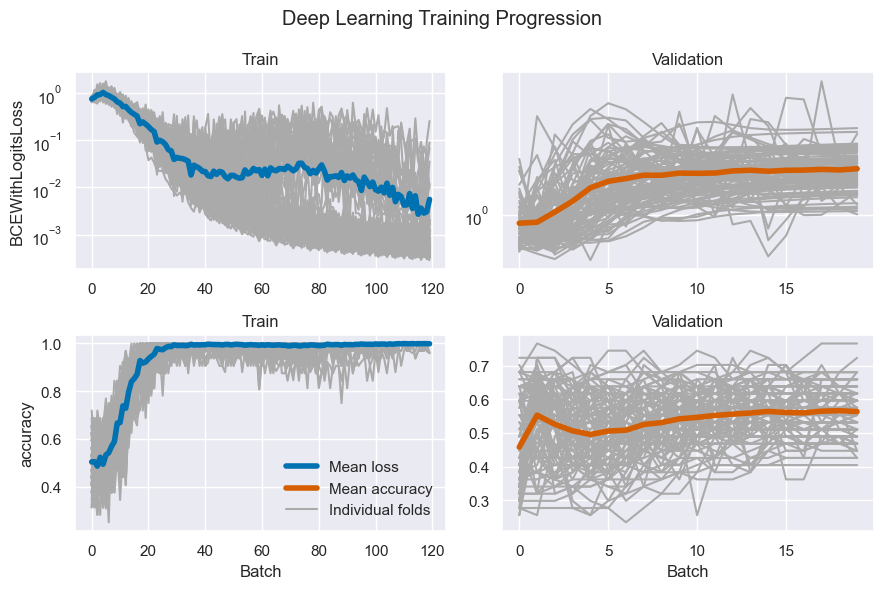

In [40]:
# Specify which DL result to look at as an deep learning configuration:
a_dl_res = dl_aggregates['2DT']['dbc_no']['All']['Fold']['ResNet']['is_responder'] # A Deep Learning Result
# Show it
lw = 4
dl_fig, axes = plt.subplots(2,2, figsize=(9,6))
line_colors = colors.blue, colors.orange
for u, (partition_name, partition) in enumerate(a_dl_res.items()):
  for v, (metric_name, metric_values) in enumerate(partition.items()):
    # Plot all learning curves
    axes[v, u].plot(metric_values.T,       color='#aaa')
    # Plot the mean learning curve
    axes[v, u].plot(metric_values.mean(0), color=line_colors[u], lw=lw)
    axes[v, u].set(
        title=f'{partition_name.capitalize()}',
        ylabel=metric_name if not u else None,
        xlabel='Batch' if v else None,
        yscale='log' if 'Log' in metric_name else 'linear',
    )
    # Only draw a legend once
    if not u and v:
        axes[v, u].legend(frameon=False, handles=[
            Line2D([], [], color=line_colors[u], label='Mean loss', linewidth=lw, ),
            Line2D([], [], color=line_colors[v], label='Mean accuracy', linewidth=lw, ),
            Line2D([], [], color='#aaaaaa',  label='Individual folds')],
        )
dl_fig.suptitle('Deep Learning Training Progression')
dl_fig.tight_layout()
dl_fig.savefig(figdir.append(f'dl_training.png'))
dl_fig.show()

## 5. Statistics
From our results we will compute statistics and add them to the data frame to create a data frame aptly called:  `results_and_stats`
These statistics are: population size, T-statisic, p-value, Bayes factor and Effect size.

In [41]:
stat_values = []
for multiindex, (null, score) in results_table.iterrows():
  _, dtype, _, _, cv_name, population_name = multiindex
  pop_idxs = population_indices[population_name]['roi'] if dtype == 'roi' else population_indices[population_name]['vec']
  n_subjs = len(pop_idxs)
  if isinstance(null, Iterable) and not np.isnan(score).all():
    k = n_splits if cv_name == 'Fold' else len(null)
    tstat, pval = corr_rep_kfold_cv_test(score, null, k, n_subjs)
    bf = bayesfactor_ttest(tstat, nx=n_subjs, paired=True)
    bf = bf if bf < 100 else 100
    d2 = compute_effsize(score, null, paired=True)
  else:
    tstat, pval, bf, d2 = [None] * 4
  stat_values.append([n_subjs, tstat, pval, bf, d2])
stats_table = pd.DataFrame(
  data=np.array(stat_values),
  index=results_table.index,
  columns=['population', 'tstat', 'pvalue', 'bayesfactor', 'effectsize']
)
results_and_stats = pd.concat((results_table, stats_table), axis=1)
# While we are on it, let us drop the LRC since it was only for development purposes
results_and_stats = results_and_stats[[i[4] != 'LogisticRegression' for i in results_and_stats.index]]
pickle_out(results_and_stats, restats_file)
results_and_stats.head()

# Split our results for primary and exploratory analyses
cortical_results = results_and_stats.loc[(sN, sN, ['dbc_no','dbc_yes']), :]  # Limit primary analysis to cortical data
subcortical_results = results_and_stats.loc[(sN, sN, ['sub_nly','sub_add', 'sub_dbc', 'sub_all']), :]  # Limit later analysis to subcortical data

## 6. Results
### 6.1 Primary results
This line means: present the average K-Fold cross-validation result for predicting response in the entire population. These results include multiple data types (ROI, 1D-vector and 2D projection; multiple ML models (GBC, SVC, ResNet) and with and without behavioural, clinical and demographic data.

`is_strict` means that we limit our selected data frame to the value specified for the level on which a comparison is requested. i.e.: The level we are requesting a comparison for (6) is considered with predicted outcomes. Here we only want to see the value that we specified (`is_responder`). When is_strict were `False` (default), we would also see the other possible predicted values `is_female`, `is_remitter` and `is_extreme`. It would not have affected the printed value.

In [42]:
distiller = TableDistiller(cortical_results, 'is_responder', None, 'dbc_no', None, 'Fold', 'All', is_strict=True, verbose=True, spacing=15)
distiller(1)

(1) 'is_responder', 'is_extreme', 'is_female', 'is_remitter'
(2) '2DT', 'roi', 'vec', '2DA'
(3) 'dbc_yes', 'dbc_no'
(4) 'GradientBoostingClassifier', 'ResNet', 'SVC'
(5) 'Fold', 'Site'
(6) 'LongTreated', 'Hiroshima', 'SameResponders', 'Extremes', 'All'
                   bacc  |  acc   |  null  | p_val  | t_stat | L10BF  
1.is_responder    47.7%  | 52.7%  | 55.2%  | 0.459  | -0.773 | -1.001 



### 6.2 Secondary Results
#### 6.2.1 Design Configurations
This line means: present the average K-Fold cross-validation result for predicting response in the entire population. Here, we split the results out three times, based on data type, based on the inclusion of clinical data and based on the machine learning method used. `is_strict` does not have an effect here, since we do not specify any value for any level we are requesting(1, 2 and 5 are `None`).

In [43]:
distiller.is_strict = False
distiller(2, 3, 4)

                   bacc  |  acc   |  null  | p_val  | t_stat | L10BF  
2.No Significant difference (p_val: 0.409, F=0.9975) among:
 -2DT             48.8%  | 53.7%  | 55.0%  | 0.722  | -0.367 | -1.128 
 -roi             47.5%  | 52.7%  | 55.5%  | 0.443  | -0.802 | -1.024 
 -vec             47.8%  | 52.6%  | 55.0%  | 0.373  | -0.937 | -0.905 
 -2DA             47.0%  | 51.8%  | 55.0%  | 0.447  | -0.795 | -1.021 

3.No Significant difference (p_val: 0.875, t_stat0.162 BF=-1.07e+00, d=6.14e-02) between:
 -dbc_yes         48.4%  | 53.5%  | 55.3%  | 0.539  | -0.638 | -0.973 
 -dbc_no          47.7%  | 52.7%  | 55.2%  | 0.459  | -0.773 | -1.001 

4.No Significant difference (p_val: 0.555, F=0.6075) among:
 -GradientBoos... 48.0%  | 53.0%  | 55.3%  | 0.572  | -0.586 | -1.078 
 -ResNet          47.9%  | 52.7%  | 55.0%  | 0.575  | -0.581 | -1.074 
 -SVC             47.3%  | 52.3%  | 55.3%  | 0.279  | -1.153 | -0.852 



#### 6.2.2 Secondary: Effect of Leave-Site-Out CV
This line means: present the average results for predicting response in the entire population using either K-Fold os Leave-Site-Out cross validation. `is_strict` does not have an effect here, since we do not specify any value for the level we are requesting (4 is `None`)

In [44]:
distiller(5)

                   bacc  |  acc   |  null  | p_val  | t_stat | L10BF  
5.No Significant difference (p_val: 0.308, t_stat-1.082 BF=-8.53e-01, d=-1.24e+00) between:
 -Fold            47.7%  | 52.7%  | 55.2%  | 0.459  | -0.773 | -1.001 
 -Site            55.3%  | 47.8%  | 43.3%  | 0.585  | 0.566  | -0.962 



### 6.3 Explorative Results
#### 6.3.1 Performance in Subpopulations
Compared to previous analyses, we do not specify a population (level 3 is `None`). Thus, this line means: present the average results for predicting response in each of the subpopulations using K-Fold cross-validation and any type of data, machine learning method or inclusion of clinical data. Like earlier, `is_strict` does not have an effect here, since we do not specify any value for the level we are requesting (3 is `None`)

In [45]:
distiller(6)

                   bacc  |  acc   |  null  | p_val  | t_stat | L10BF  
6.Significant difference (p_val: 6.5e-19, F=99.0547) among:
 -LongTreated     49.7%  | 65.2%  | 65.6%  | 0.930  | -0.091 | -0.901 
 -Hiroshima       45.4%  | 48.5%  | 53.5%  | 0.423  | -0.840 | -0.751 
 -SameResponders  45.7%  | 50.2%  | 55.0%  | 0.269  | -1.178 | -0.704 
 -Extremes        68.6%  | 59.5%  | 43.3%  | 0.007* | 3.515  | 1.030  
 -All             47.7%  | 52.7%  | 55.2%  | 0.459  | -0.773 | -1.001 



##### 6.3.3.1 Repeating our primary analyses on the Extremes Population

In [46]:
distiller = TableDistiller(cortical_results, 'is_responder', None, 'dbc_no', None, 'Fold', 'Extremes', is_strict=True, spacing=15)
distiller(1)
distiller.is_strict = False
distiller(2, 3, 4, 5)

                   bacc  |  acc   |  null  | p_val  | t_stat | L10BF  
1.is_responder    68.6%  | 59.5%  | 43.3%  | 0.007* | 3.515  | 1.030  

                   bacc  |  acc   |  null  | p_val  | t_stat | L10BF  
2.Significant difference (p_val: 2.0e-07, F=22.0452) among:
 -2DT             69.5%  | 61.2%  | 44.1%  | 0.015* | 2.987  | 0.824  
 -roi             74.2%  | 62.1%  | 41.9%  | 0.002* | 4.201  | 1.986  
 -vec             69.5%  | 61.3%  | 44.1%  | 0.002* | 4.350  | 1.093  
 -2DA             55.4%  | 48.8%  | 44.1%  | 0.344  | 0.998  | -0.800 

3.No Significant difference (p_val: 0.204, t_stat1.370 BF=-5.39e-01, d=3.23e-01) between:
 -dbc_yes         77.7%  | 66.8%  | 43.0%  |4.4e-04*| 5.384  | 1.580  
 -dbc_no          68.6%  | 59.5%  | 43.3%  | 0.007* | 3.515  | 1.030  

4.Significant difference (p_val: 1.5e-08, F=57.7705) among:
 -GradientBoos... 66.5%  | 57.2%  | 43.0%  | 0.012* | 3.123  | 1.079  
 -ResNet          62.4%  | 55.0%  | 44.1%  | 0.078* | 1.992  | 0.012  
 -SVC 

##### 6.3.3.2 Explorative III: Prediction OF Extremes

In [47]:
distiller = TableDistiller(results_and_stats, 'is_extreme', None, None, None, 'Fold', 'All')
distiller(3)

                        bacc  |  acc   |  null  | p_val  | t_stat | L10BF  
3.Significant difference (p_val: 2.5e-07, F=11.7981) among:
 -dbc_no               61.0%  | 52.8%  | 43.2%  | 0.027* | 2.629  | 0.359  
 -sub_all              62.6%  | 54.3%  | 43.4%  | 0.010* | 3.257  | 1.130  
 -sub_nly              57.6%  | 50.0%  | 43.4%  | 0.087* | 1.924  | -0.286 
 -sub_add              59.5%  | 51.7%  | 43.4%  | 0.044* | 2.343  | 0.034  
 -sub_dbc              62.6%  | 54.3%  | 43.4%  | 0.010* | 3.251  | 1.115  
 -dbc_yes              62.5%  | 54.1%  | 43.3%  | 0.015* | 2.996  | 0.764  



#### 6.3.2 Explorative II: Subcortical based Prediction

In [48]:
added_data = results_and_stats.index.get_level_values(2)
subc_compare = results_and_stats[np.logical_or(added_data == 'dbc_no', added_data == 'sub_add')]
distiller = TableDistiller(subc_compare, 'is_responder', None, None, None, 'Fold', 'All')
distiller(3)

                        bacc  |  acc   |  null  | p_val  | t_stat | L10BF  
3.No Significant difference (p_val: 0.251, t_stat-1.228 BF=-8.39e-01, d=-3.34e-01) between:
 -dbc_no               47.7%  | 52.7%  | 55.2%  | 0.459  | -0.773 | -1.001 
 -sub_add              50.5%  | 56.1%  | 55.5%  | 0.885  | 0.148  | -1.157 



In [49]:
distiller = TableDistiller(cortical_results, 'is_responder', None, 'dbc_no', None, 'Fold', 'LongTreated', is_strict=True, verbose=False, spacing=15)
distiller(1)
distiller.is_strict = False
distiller(2, 3, 4, 5)

                   bacc  |  acc   |  null  | p_val  | t_stat | L10BF  
1.is_responder    49.7%  | 65.2%  | 65.6%  | 0.930  | -0.091 | -0.901 

                   bacc  |  acc   |  null  | p_val  | t_stat | L10BF  
2.Significant difference (p_val: 5.8e-06, F=15.0800) among:
 -2DT             46.9%  | 61.6%  | 65.6%  | 0.361  | -0.963 | -0.796 
 -roi             49.1%  | 64.4%  | 65.6%  | 0.785  | -0.281 | -0.968 
 -vec             53.5%  | 70.2%  | 65.6%  | 0.344  | 0.999  | -0.781 
 -2DA             50.1%  | 65.7%  | 65.6%  | 0.943  | 0.074  | -0.991 

3.No Significant difference (p_val: 0.610, t_stat-0.528 BF=-8.44e-01, d=-1.24e-01) between:
 -dbc_yes         49.7%  | 65.2%  | 65.6%  | 0.838  | -0.211 | -0.829 
 -dbc_no          49.7%  | 65.2%  | 65.6%  | 0.930  | -0.091 | -0.901 

4.Significant difference (p_val: 0.014, F=5.4197) among:
 -GradientBoos... 51.0%  | 66.8%  | 65.6%  | 0.797  | 0.266  | -0.864 
 -ResNet          48.5%  | 63.6%  | 65.6%  | 0.667  | -0.445 | -0.894 
 -SVC  

### 6.4 Visuals of performance over several analyses

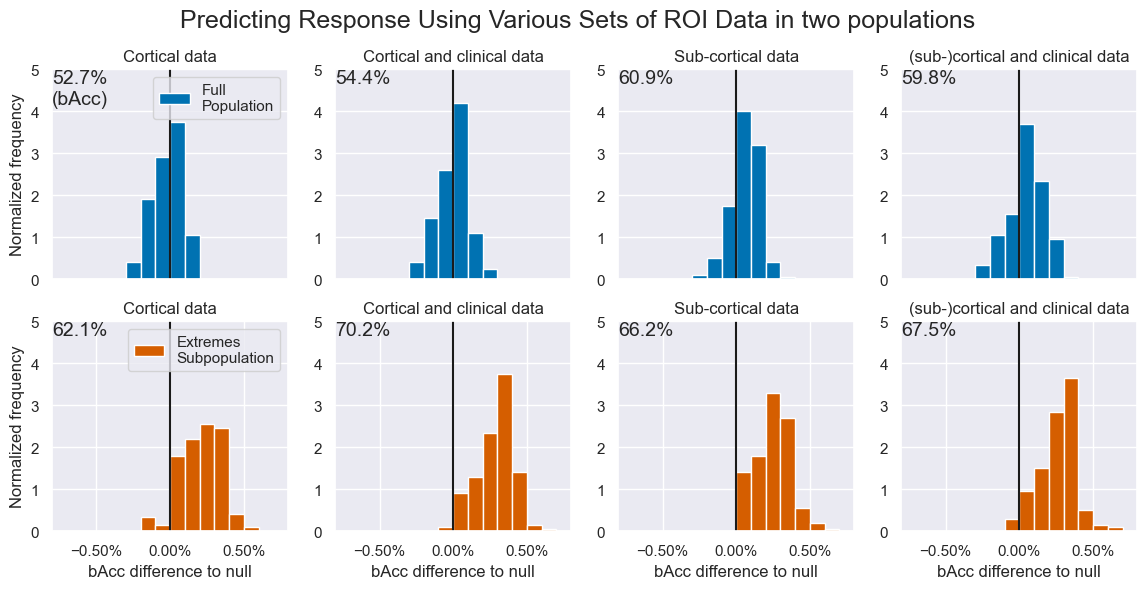

In [50]:
# Human-readable Title Dictionaries
hr_data = {
  'sub_dbc': 'sub-cortical and clinical',
  'sub_nly': 'sub-cortical',
  'dbc_no':  'cortical',
  'dbc_yes': 'cortical and clinical',
  'sub_all': '(sub-)cortical and clinical',
  'sub_add': '(sub-)cortical',
}
hr_pop = {
  'All': 'Full\nPopulation',
  'Extremes': 'Extremes\nSubpopulation',
}

bins = np.linspace(-.8, .8, 17)
queries = (
  ('is_responder', 'roi', 'dbc_no',   sN, 'Fold', 'All',),
  ('is_responder', 'roi', 'dbc_yes',  sN, 'Fold', 'All',),
  ('is_responder', 'roi', 'sub_nly',  sN, 'Fold', 'All',),
  ('is_responder', 'roi', 'sub_all',  sN, 'Fold', 'All',),
  ('is_responder', 'roi', 'dbc_no',   sN, 'Fold', 'Extremes',),
  ('is_responder', 'roi', 'dbc_yes',  sN, 'Fold', 'Extremes',),
  ('is_responder', 'roi', 'sub_nly',  sN, 'Fold', 'Extremes',),
  ('is_responder', 'roi', 'sub_all',  sN, 'Fold', 'Extremes',),
)

n_rows = 2
n_cols = 4
xlim = .8
ylim = 5 # max(ax.get_ylim()) # example.population.mean() #

cs = [colors.blue] * 4 + [colors.orange] * 4
bacc_fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6))
for ax_n, query, ax, c in zip(range(n_rows * n_cols), queries, axes.reshape(-1), cs):
  title = '{} data'.format(hr_data[query[2]])
  # Get data
  example = results_and_stats.loc[query]
  score, null = example['score'], example['null']
  try:
    score, null = score.dropna(), null.dropna()
  except AttributeError:
    pass
  if len(example.shape) > 1:
    score, null = flatten(score), flatten(null)

  # Plot
  ax.hist(np.subtract(score, null), bins, density=True, color=c, label=hr_pop[query[-1]])
  ax.plot([0, 0], [0, ylim], c='k')
  acc_explainer = '' if ax_n else '(bAcc)'
  if not ax_n % n_cols:
    ax.legend()
  ax.text(-xlim, ylim, f'{np.mean(score):.1%}\n{acc_explainer}', va='top', size=14)
  # Format the plot
  ax.set(
    xlim=(-xlim, xlim),
    ylim=(0, ylim),
    title=title.capitalize(),
  )
  if not ax_n % n_cols:
    ax.set_ylabel('Normalized frequency')
  ax.set_xlabel('bAcc difference to null')
  if ax_n < n_cols:
    ax.get_xaxis().set_visible(False)
  ax.xaxis.set_major_formatter(mtick.PercentFormatter())
  plt.suptitle('Predicting Response Using Various Sets of ROI Data in two populations', fontsize=18)
bacc_fig.savefig(figdir.append(f'bAcc_histograms.png'))

## Sidenotes
### Secondary Results

Three things are worth mentioning about these results:
1. Why the null score for `Site` is < 50%
2. Why the null score for `Extremes` is < 50%
3. How the bAcc > 50% when Acc < Null

The reasons are:
1. Because sites present varying a-priori response rates, but the mean of all sites is around 50%. This implies that, when a site with dominant class A is in the test set, the dominant class in the train set will likely be B. Thus we often see a mismatch between dominant class in the train set and the test set.
2. The classes in the entire data set are balanced 50%/50%. When we use (even stratified) cross-validation, whenever there are more samples of class A in the train set, there will be more samples of B in the test set. This will incur a deviation from the 50% balance of size ~ `1/(sample_size/n_splits)` (deviates due to rounding of test set sizes).
3. Because the "mean of balanced accuracies" != "the balanced accuracy of the means"

Based on simple calculations using the subject samples and labels we can provide an estimate of the expected `null score` and compare this with the measured null score:

In [51]:
measured_sites_accs = [np.mean(flatten(results_and_stats.loc[q]['null'])) for q in (
    ('is_responder', sN, sN, sN, 'Fold', 'Extremes'), ('is_responder', 'roi', sN, sN, 'Site', 'All')
)]

In [52]:
# Retrieve the accuracy score from our results
queries = ('Fold', 'Extremes'), ('Site', 'All')
measured_sites_accs = [np.mean(flatten(results_and_stats.loc[('is_responder', sN, sN, sN, *q)]['null'])) for q in queries]

print('We can say the following about the null accuracy score:')
for i, ((cv_name, (cv_scheme, _)), example_population, measured_sites_acc) in enumerate(zip(cv_schemes.items(), ('Extremes', 'All'), measured_sites_accs), 1):
  # Simulate simple
  Xt, yt, ct, = data_dict['roi']['dbc_no'][example_population]
  yt = yt.is_responder

  sites_acc = []
  dominant_class_mismatches, n_splits = 0, 0
  for train_idx, test_idx in cv_scheme.split(yt, y=yt, groups=ct):
    n_splits += 1
    dominant_class_in_train = yt.iloc[train_idx].mode()[0].item()
    dominant_class_in_test= yt.iloc[test_idx].mode()[0].item()
    if dominant_class_in_train != dominant_class_in_test:
      dominant_class_mismatches += 1
    test_samples = yt.iloc[test_idx]
    sites_acc.append(np.mean(test_samples == dominant_class_in_train))

  print(f'{i}.  In Leave-{cv_name}-Out CV of {example_population} the dominant class was mismatched {dominant_class_mismatches}/{n_splits} times:\n'
        f'    - Expected: {np.mean(sites_acc):.1%}\n'
        f'    - Measured: {measured_sites_acc:.1%}\n')

s = results_and_stats.loc['is_responder', '2DT', 'dbc_no', 'ResNet', 'Fold', 'All']['score']
n = results_and_stats.loc['is_responder', '2DT', 'dbc_no', 'ResNet', 'Fold', 'All']['null']
print(f'3.  The mean-balanced-accuracy (bAcc) is not the same as balanced-accuracy of the means:\n'
      f'    Mean accuracy score: {np.mean(s):.1%} ± {np.std(s):.1%}, Mean null score: {np.mean(n):.1%} ± {np.std(n):.1%}\n'
      f'    - Balanced accuracy of means:  {np.mean(s)/np.mean(n)/2:.1%}\n'
      f'    - Mean of balanced accuracies: {np.mean([i/j/2 for i, j in zip(s, n)]):.1%}\n')

We can say the following about the null accuracy score:
1.  In Leave-Fold-Out CV of Extremes the dominant class was mismatched 80/100 times:
    - Expected: 46.9%
    - Measured: 42.6%

2.  In Leave-Site-Out CV of All the dominant class was mismatched 4/6 times:
    - Expected: 43.6%
    - Measured: 43.4%

3.  The mean-balanced-accuracy (bAcc) is not the same as balanced-accuracy of the means:
    Mean accuracy score: 53.7% ± 9.2%, Mean null score: 55.0% ± 7.7%
    - Balanced accuracy of means:  48.8%
    - Mean of balanced accuracies: 49.5%



Now previously, I have attempted to fix this by replacing in this notebook:
```
  previous_result['null'] = [np.mean(y[test] == y[train].mode()[0]) for train, test in list(split_null)]
```
with
```
  previous_result['null'] = np.array([np.mean(y[test]) if y.mean() == 0.5 else np.mean(y[test] == y[train].mode()[0]) for train, test in list(split_null)])
```
And adding a special case in the `torch_val_score` method when `if y.mean() == 0.5`. But creates an overestimation of the performance and only makes the results harder to interpret, so I have since removed them.

In [76]:
n_splits = 10
n_repeats = 10
importance_array = np.zeros((n_splits * n_repeats, len(bool_var)))

pipeline = make_pipeline(imputer, combat, scaler, selector, classifiers[0], )
X, ys, c = data_dict['vec']['dbc_no']['Extremes']
y = ys['is_responder']
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=0)

for fold_no, (train_index, test_index) in enumerate(tqdm(cv.split(X, y))):
  X_train, y_train = X.iloc[train_index], y.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  clf = pipeline.fit(X_train, y_train)[-1]
  map_imp = deepcopy(bool_var)
  coef_counter = 0
  for pixel_no, zero_var in enumerate(bool_var):
    if zero_var:
      map_imp[pixel_no] = 0
    else:
      map_imp[pixel_no] = clf.coef_[0][coef_counter]
      coef_counter += 1
  importance_array[fold_no, :] = np.array(map_imp, )

100it [00:10,  9.31it/s]


## 6. Interpretarion of Cortical Results
### Calculate
We run simulations for two populations `All` and `Extremes` and two data types, . We store the coefficients in a dictionary called `coef_dict`.

In [53]:
# Parameters of our simulation
n_splits = 40
n_repeats = 2

# Preallocate an array to which we can store the feature importance
importance_array = np.zeros((n_splits * n_repeats, len(bool_var)))

# Define the machine learning pipeline
combat = list(cv_schemes.values())[-1][-1]
pipeline = make_pipeline(imputer, combat, scaler, selector, classifiers[0], )

# Preallocate two dictionaries: One to store the simulation bAccs, one to store results
coef_bacc = make_empty_nest(['All', 'Extremes'], ['dbc_no', 'sub_all'], bottom=[])
coef_dict = deepcopy(coef_bacc)

# We use a ROS to balanced training data. Test data is balanced through RSKF-CV.
ros = RandomOverSampler()

for population_name, coef_dict_b in coef_dict.items():
  for data_type in coef_dict_b:
    X, y, _ = data_dict['roi'][data_type][population_name]
    y = y['is_responder']
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=0)
    coef_df = pd.DataFrame(columns=X.columns)
    accs = []
    for train_index, test_idx in tqdm(cv.split(X, y)):
      X_train, y_train = X.iloc[train_index], y.iloc[train_index]
      X_train, y_train, = ros.fit_resample(X_train, y_train)
      X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
      X_test, y_test = ros.fit_resample(X_test, y_test)

      pipeline = make_pipeline(imputer, scaler, selector, classifiers[-1], )
      pipeline.fit(X_train, y_train)
      clf = pipeline[-1]
      y_pred = pipeline.predict(X_test)

      # We have already used ROS, so Acc = bAcc, but just for good measure:
      bacc = balanced_accuracy_score(y_test, y_pred)

      coef_df.loc[len(coef_df)] = clf.feature_importances_
      accs.append(bacc)

    coef_dict[population_name][data_type] = coef_df.mean()
    coef_bacc[population_name][data_type] = np.mean(accs)

80it [04:56,  3.70s/it]
80it [01:34,  1.18s/it]
80it [02:19,  1.74s/it]
80it [00:48,  1.65it/s]


In [89]:
coef_dict_b.keys()

dict_keys(['dbc_no', 'sub_all'])

### Cortical Show
Show fancy

In [59]:
inv_dkt_atlas_lut = {v: k for k, v in dkt_atlas_lut.items()}
coef_means = coef_dict['Extremes']['dbc_no']
lut_dir = get_root('data', 'fsaverage', 'manual_labels')
os.makedirs(lut_dir, exist_ok=True)
dfs = []
for hm in "Left", "Right": #, "Mean":
  for letter in 'surf', 'thick':
    lut_fname = lut_dir.append(f'{hm[0]}H-LRC_{letter}-coefs-All.pkl')
    if not os.path.isfile(lut_fname):
      sd = np.std([v for i, v in coef_means.items() if letter in i and i[0] == hm[0]])
      idx2coef = make_coef_lut(coef_means, hm=hm[0], property=letter, sd=sd)
      # pickle_out(idx2coef, lut_fname)
      lut_status = 'created'
    else:
      idx2coef = pickle_in(lut_fname)
      lut_status = 'existed'
    dfs.append(pd.Series({inv_dkt_atlas_lut[k]: v for k, v in idx2coef.items()}, name=f'{hm}_{letter}'))
    print(f'Coefficient Look-Up-Table {lut_status} for {letter} in {hm} hemisphere. ({lut_fname})')
pd.concat(dfs, axis=1)

Coefficient Look-Up-Table created for surf in Left hemisphere. (D:\repositories\ENIGMA\data\fsaverage\manual_labels\LH-LRC_surf-coefs-All.pkl)
Coefficient Look-Up-Table created for thick in Left hemisphere. (D:\repositories\ENIGMA\data\fsaverage\manual_labels\LH-LRC_thick-coefs-All.pkl)
Coefficient Look-Up-Table created for surf in Right hemisphere. (D:\repositories\ENIGMA\data\fsaverage\manual_labels\RH-LRC_surf-coefs-All.pkl)
Coefficient Look-Up-Table created for thick in Right hemisphere. (D:\repositories\ENIGMA\data\fsaverage\manual_labels\RH-LRC_thick-coefs-All.pkl)


,Left_surf,Left_thick,Right_surf,Right_thick
bankssts,0.643855,0.541430,0.562666,0.507108
caudalanteriorcingulate,0.567701,0.733235,0.522524,0.514099
caudalmiddlefrontal,0.642038,0.906931,0.548492,0.600773
cuneus,0.536207,1.000000,0.505479,0.534859
fusiform,0.577333,1.000000,0.911493,0.539551
inferiorparietal,0.551305,0.508568,1.000000,0.510214
inferiortemporal,0.717719,1.000000,0.505413,0.519976
isthmuscingulate,0.632802,0.572012,0.862409,0.503618
lateraloccipital,0.530461,1.000000,0.715594,0.503964
lateralorbitofrontal,0.668558,0.607515,0.509124,0.521879


In [61]:
# inverse the dkt_atlas
population = 'Extremes'

dkt_atlas_lut_ud = {v:k for k, v in dkt_atlas_lut.items()}
colnames = []
feature_importances = []
for hm in 'LR':
  for letter in 'surf', 'thick':
    # load the LUT
    lut_fname = lut_dir.append(f'{hm}H-LRC_{letter}-coefs-{population}.pkl')
    feature_importances.append({dkt_atlas_lut_ud[k]:v for k, v in pickle_in(lut_fname).items()})
    colnames.append(f'{hm}H_{letter}')
print(f'Coefficients as provided for imaging of the {population} population:')
pd.DataFrame(feature_importances, index=colnames).T

Coefficients as provided for imaging of the Extremes population:


,LH_surf,LH_thick,RH_surf,RH_thick
bankssts,0.225564,0.400976,0.725218,0.318618
caudalanteriorcingulate,0.714526,0.733274,0.236932,0.532695
caudalmiddlefrontal,0.716545,0.559250,0.547786,0.429713
cuneus,0.553615,0.519163,0.594030,0.218352
fusiform,0.694217,0.114038,0.173524,0.370372
inferiorparietal,0.622145,0.666933,0.952800,0.644766
inferiortemporal,0.262894,0.000000,0.310763,0.412891
isthmuscingulate,0.348311,0.566538,0.361238,0.514188
lateraloccipital,0.528657,0.814262,0.290009,0.444446
lateralorbitofrontal,0.617164,0.346796,0.384433,0.207585


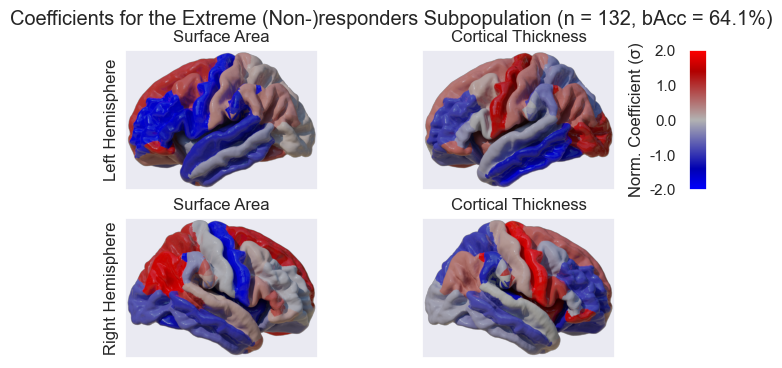

In [63]:
#show colormap
n_shades = 200
cbar_lim = -2, 2
colorbar = get_rgb_cbar(n_shades=n_shades)

# #Plot with label brain (annot)
# imgs = 'lh_annot', 'lh_surf', 'lh_thick', 'colorbar', 'rh_annot', 'rh_surf', 'rh_thick',
# imgs_fpath = r"D:\repositories\ENIGMA\documents\graphics\Blender\{}.png"
# img_titles = 'Labels', 'Surface Coefficients', 'Thickness Coefficients', '',\
#              'Labels', 'Surface Coefficients', 'Thickness Coefficients',

#Plot without label brain (annot)
imgs = 'lh_surf', 'lh_thick', 'colorbar','rh_surf', 'rh_thick',
imgs_fpath = figdir.append('{}.png')
img_titles = 'Surface Area', 'Cortical Thickness', '',\
             'Surface Area', 'Cortical Thickness',

n_rows = 2
n_cols = len(imgs) // n_rows
for img_pop in ('Extremes', ):
  brain_fig, axes = plt.subplots(nrows=n_rows,
                           ncols=len(imgs) // n_rows + 1,
                           figsize=(n_cols * 3 + 2, 2 * n_rows),
                           gridspec_kw={'width_ratios': n_cols * [1] + [0.1]})
  axes = axes.reshape(-1)
  for ax, title, img_path in zip(axes, img_titles, imgs):
    # Select and display image
    formatted_img_path = imgs_fpath.format(img_path if 'annot' in img_path else f'{img_path}_{img_pop}')
    img = colorbar if img_path == 'colorbar' else mpimg.imread(formatted_img_path)
    ax.imshow(img)

    # Set axes properties
    ax.set(xticks=[], title=title)
    if img_path == 'colorbar':
      ax.set_yticks(np.linspace(0, n_shades, 5))
      ax.grid(False)
      ax.set_yticklabels(np.linspace(cbar_lim[-1], cbar_lim[0], 5))
      ax.set_ylabel('Norm. Coefficient (σ)')
    else:
      ax.set_yticks([])
  axes[-1].axis('off')
  axes[0].set_ylabel('Left Hemisphere')
  axes[n_cols + 1].set_ylabel('Right Hemisphere')
  perf = results_dict['roi']['dbc_no'][img_pop]['Fold']['LogisticRegression']['is_responder']
  bacc = np.divide(perf['score'], perf['null']).mean() / 2
  n_part = len(data_dict['roi']['dbc_no'][img_pop][0])
  # plt.suptitle(f'Coefficients for {img_pop} Population (n = {n_part:.0f}, bAcc = {bacc:.1%})')
  plt.suptitle(f'Coefficients for the Extreme (Non-)responders Subpopulation (n = {n_part:.0f}, bAcc = {0.641:.1%})')
  brain_fig.savefig(figdir.append(f'{img_pop}-3Dbrains.tiff'))
plt.show()

100%|██████████| 258/258 [00:00<00:00, 2778.57it/s]


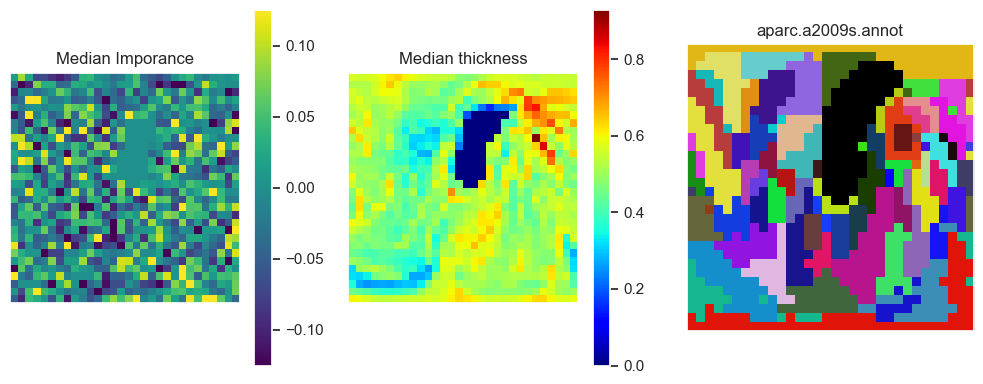

In [78]:
X_thc2, _ = load_proj_df(data, 'Thickness')

titles = 'Median Imporance', 'Median thickness', 'aparc.a2009s.annot'

map_imp = np.reshape(np.median(importance_array, axis=0), [30, 30])
map_thk = np.reshape(np.median(X_thc2, axis=0), [30, 30])
map_img = np.load(results_dir.append('aggregated_label_annot_res-32.npy'))

fig, axes = plt.subplots(1, len(titles), figsize=(10,4))
h_thk = axes[0].imshow(map_imp, cmap='viridis', clim=(-map_imp.std() * 2, map_imp.std() * 2), )
h_imp = axes[1].imshow(map_thk, cmap='jet')
h_img = axes[2].imshow(map_img)


for ax, mappable, title in zip(axes, [h_thk, h_imp, None], titles):
  ax.grid(False)
  ax.set(title=title, xticks=[], yticks=[])
  if mappable:
    fig.colorbar(mappable, ax=ax)
fig.tight_layout()
fig.show()

Note that the labeling we were provided in the ROI analysis (`aparc.DKTatlas40.annot`) is different from the labeling we were provided in the projection analysis (`aparc.a2009s.annot`) which is shown in the figure above. Also, one is not simply as subset of the other.

I Wish we would have the DKTatlas for the projection data so we could see if the importance found in the projection analysis lines up with the importance found in the ROI analysis.

### Subcortical Show
Show a table

In [201]:
# A function to strip subcortical ROIs from their hemisphere information
rm_hem = lambda x: x[1:] if x[0] in hems else x

# Get hemisphere options, and ROI options so we can strip them from column names
hems = 'LRM'

# Features of interest, pick one
feature_set = ['sub_all', 'dbc_no'][0]

imp_dfs = {}
for population, population_coef_dict in coef_dict.items():
    bacc = np.mean(coef_bacc[population][feature_set])

    # Apply the subcortical strip function to the index to get all unique ROIs
    no_hem_subc_rois = set(population_coef_dict[feature_set].index.map(rm_hem))

    # Preallocate a numpty array to store our
    subc_coefs = np.empty((len(no_hem_subc_rois), len(hems)))
    subc_coefs[:] = np.nan

    # Collect coef by ROI and hemisphere, and appoint directly into a numpy array
    for i, v in subc.items():
        roi_name = rm_hem(i)
        hemi = i.replace(roi_name, '')
        hemi = hemi if hemi else 'M'
        x = list(no_hem_subc_rois).index(roi_name)
        y = hems.index(hemi)
        subc_coefs[x, y] = v
    subc_coefs = np.concatenate([subc_coefs, np.nansum(np.abs(subc_coefs), 1)[:, np.newaxis]], axis=1)

    # Convert the array to a table, and do formatting
    subc_relevance_table = pd.DataFrame(data=subc_coefs, columns=list(hems) + ['SAR'], index=no_hem_subc_rois)  # We use Sum of Absolute Relevances
    subc_relevance_table = subc_relevance_table.sort_values(by='SAR', ascending=False)                          # for sorting
    subc_relevance_table = subc_relevance_table.drop(columns=['SAR'])                                           # and drop it after.
    subc_relevance_table = subc_relevance_table.replace(np.nan, pd.NA)
    subc_relevance_table = subc_relevance_table.rename(columns={'L': 'Left', 'R': 'Right', 'M': 'Middle / NA'})

    # Store the table
    imp_dfs[population] = subc_relevance_table

In [202]:
imp_dfs['All']

,Left,Right,Middle / NA
pal,0.02158,0.06113,0.010613
accumb,0.031043,0.035328,0.017012
Normalized_Pretreatment_Severity,<NA>,<NA>,0.081625
amyg,0.030065,0.024612,0.011932
thal,0.016774,0.013497,0.022554
is_ad,<NA>,<NA>,0.035715
hippo,0.009358,0.008916,0.013837
caud,0.013836,0.004597,0.009862
ICV,<NA>,<NA>,0.026178
Age_of_Onset,<NA>,<NA>,0.020923


In [83]:
imp_dfs['Extremes']

,Left,Right,Middle / NA
pal,0.02158,0.06113,0.010613
accumb,0.031043,0.035328,0.017012
Normalized_Pretreatment_Severity,<NA>,<NA>,0.081625
amyg,0.030065,0.024612,0.011932
thal,0.016774,0.013497,0.022554
is_ad,<NA>,<NA>,0.035715
hippo,0.009358,0.008916,0.013837
caud,0.013836,0.004597,0.009862
ICV,<NA>,<NA>,0.026178
Age_of_Onset,<NA>,<NA>,0.020923


In [84]:
print('start time:', results_uid)
print('finish time:', datetime.now().strftime("%Y%m%d-%H%M%S"))

start time: 20231103-190844
finish time: 20240320-135635
